This file contains python code to check the hypothesis testing

In [1]:
RUN_PYTHON_SCRIPT = False
#OUTLIER_IDXS = dict(AD=[], ctrl=[])
OUTLIER_IDXS = dict(AD=[49], ctrl=[14, 19, 30, 38])
SAVED_FOLDER = "real_data_nlinear_test"
DATA = ["AD88_matlab_1-45.pkl", "Ctrl92_matlab_1-45.pkl"]

['AD88_matlab_1-45.pkl', 'Ctrl92_matlab_1-45.pkl']

In [2]:
import sys
sys.path.append("../../mypkg")


In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number
import itertools

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
from IPython.display import display
from joblib import Parallel, delayed

In [4]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [5]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from hdf_utils.data_gen import gen_simu_sinica_dataset
from hdf_utils.SIS import SIS_GLIM
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.opt import HDFOpt
from hdf_utils.fns_sinica import  fourier_basis_fn

from joblib import Parallel, delayed

In [6]:
plt.style.use(FIG_ROOT/"base.mplstyle")

In [7]:
torch.set_default_tensor_type(torch.DoubleTensor)
def_dtype = torch.get_default_dtype()

torch.float64

# Load  data and prepare

In [8]:
data_root = DATA_ROOT/"AD_vs_Ctrl_PSD/";
AD_PSD = load_pkl(data_root/DATA[0]);
ctrl_PSD = load_pkl(data_root/DATA[1]);
df0= pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt.csv");
df1= pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt_more.csv");
df1 = df1.set_index("RID")
df0 = df0.set_index("RID");
df1 = df1.reindex(df0.index)
baseline = df1
baseline["Gender_binary"] = baseline["Gender"].apply(lambda x: 0 if x=="female" else 1);
baseline["Grp_binary"] = baseline["Grp"].apply(lambda x: 1 if x=="AD" else 0);

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/AD88_matlab_1-45.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/Ctrl92_matlab_1-45.pkl


In [9]:
# The outlier idxs to rm
outlier_idxs = np.concatenate([OUTLIER_IDXS["AD"], len(AD_PSD.PSDs)+np.array(OUTLIER_IDXS["ctrl"])])
outlier_idxs = outlier_idxs.astype(int)

# make PSD in dB and std 
raw_X = np.concatenate([AD_PSD.PSDs, ctrl_PSD.PSDs]); #n x d x npts
X_dB = 10*np.log10(raw_X);
outlier_idxs2 = np.where(X_dB.mean(axis=(1, 2))<0)
#X = (X_dB - X_dB.mean(axis=-1, keepdims=1))/X_dB.std(axis=-1, keepdims=1);
X = X_dB

Y = np.array(baseline["MMSE"])[:X.shape[0]];
# if logi
#Yb = np.array(baseline["Grp_binary"])[:X.shape[0]];

sel_cov = ["Gender_binary", "MEG_Age","Education"]
Z_raw = np.array(baseline[sel_cov])[:X.shape[0]];

grp_idxs = np.array(baseline["Grp"])[:X.shape[0]];


outlier_idxs = np.sort(np.union1d(outlier_idxs, outlier_idxs2))


# remove outliers
X = np.delete(X, outlier_idxs, axis=0)
Y = np.delete(Y, outlier_idxs, axis=0)
Z_raw = np.delete(Z_raw, outlier_idxs, axis=0)
grp_idxs = np.delete(grp_idxs, outlier_idxs, axis=0)


#remove nan
keep_idx = ~np.bitwise_or(np.isnan(Y), np.isnan(Z_raw.sum(axis=1)));
X = X[keep_idx];
Y = Y[keep_idx]
Z_raw = Z_raw[keep_idx]
grp_idxs = grp_idxs[keep_idx]

Z = np.concatenate([np.ones((Z_raw.shape[0], 1)), Z_raw], axis=1); # add intercept


freqs = AD_PSD.freqs;
# only take PSD between [2, 35] freqs of interest
X = X[:, :, np.bitwise_and(freqs>=2, freqs<=35)]
X = X/X.mean()


print(X.shape, Y.shape, Z.shape)

all_data = edict()
all_data.X = torch.tensor(X)
#all_data.X = torch.tensor(X+np.random.randn(*X.shape)*0.1)
all_data.Y = torch.tensor(Y)
all_data.Z = torch.tensor(Z)


(143, 68, 74) (143,) (143, 4)


In [10]:
# atlas
rois = np.loadtxt(DATA_ROOT/"dk68_utils/ROI_order_DK68.txt", dtype=str);

# Param and fns

## Params

In [33]:
from easydict import EasyDict as edict
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from copy import deepcopy
from scenarios.base_params import get_base_params

base_params = get_base_params("linear") 
base_params.data_params = edict()
base_params.data_params.d = all_data.X.shape[1]
base_params.data_params.n = all_data.X.shape[0]
base_params.data_params.npts = all_data.X.shape[-1]
base_params.data_params.freqs = AD_PSD.freqs

base_params.can_Ns = [4, 6, 8, 10, 12, 14]
base_params.SIS_params = edict({"SIS_pen": 0.02, "SIS_basis_N":8, "SIS_ws":"simpson"})
base_params.opt_params.beta = 10 
base_params.can_lams = [0.60,  0.80,  1,  1.2, 1.4, 1.6, 2.0, 4.0]


setting = edict(deepcopy(base_params))
add_params = edict({})
add_params.setting = "real_data_linear"
add_params.SIS_ratio = 0.2
setting.update(add_params)

In [34]:
save_dir = RES_ROOT/SAVED_FOLDER
if not save_dir.exists():
    save_dir.mkdir()

In [35]:
bands_cut = edict()
bands_cut.delta = [2, 4]
bands_cut.theta = [4, 8]
bands_cut.alpha = [8, 12]
bands_cut.beta = [12, 35]
bands_cut.pts = [4, 8, 12, 35]

cut_pts = np.abs(freqs.reshape(-1, 1) - bands_cut.pts).argmin(axis=0)

array([ 7, 16, 25, 76])

In [36]:
def _run_fn(roi_idx, lam, N, setting, is_save=False, is_cv=False, verbose=2):
    torch.set_default_dtype(torch.double)
        
    _setting = edict(setting.copy())
    _setting.lam = lam
    _setting.N = N
    _setting.sel_idx = np.delete(np.arange(setting.data_params.d), [roi_idx])
    
    
    f_name = f"roi_{roi_idx:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}_fit.pkl"
    
    
    if not (save_dir/f_name).exists():
        hdf_fit = HDFOpt(lam=_setting.lam, 
                         sel_idx=_setting.sel_idx, 
                         model_type=_setting.model_type,
                         verbose=verbose, 
                         SIS_ratio=_setting.SIS_ratio, 
                         N=_setting.N,
                         is_std_data=True, 
                         cov_types=None, 
                         inits=None,
                         model_params = _setting.model_params, 
                         SIS_params = _setting.SIS_params, 
                         opt_params = _setting.opt_params,
                         bsp_params = _setting.bsp_params, 
                         pen_params = _setting.pen_params
               );
        hdf_fit.add_data(all_data.X, all_data.Y, all_data.Z)
        opt_res = hdf_fit.fit()
        
        if is_cv:
            hdf_fit.get_cv_est(_setting.num_cv_fold)
        if is_save:
            hdf_fit.save(save_dir/f_name, is_compact=False, is_force=True)
    else:
        hdf_fit = load_pkl(save_dir/f_name, verbose>=2);
        
    return hdf_fit


In [37]:
setting.model_params.ws = "sim"
setting.bsp_params.is_orth_basis = True
res = _run_fn(1, lam=0.8, N=10, setting=setting);

2024-03-14 16:02:55,107 - optimization.opt - INFO - opt params is {'stop_cv': 0.0005, 'max_iter': 2000, 'one_step_verbose': 0, 'alpha': 0.9, 'beta': 10, 'R': 200000.0, 'linear_theta_update': 'cholesky_inv'}.
2024-03-14 16:02:55,108 - optimization.opt - INFO - SIS params is {'SIS_pen': 0.02, 'SIS_basis_N': 8, 'SIS_basis_ord': 4, 'SIS_ratio': 0.2, 'SIS_ws': 'simpson'}.
2024-03-14 16:02:55,109 - optimization.opt - INFO - model params is {'norminal_sigma2': 1, 'ws': 'sim'}.
2024-03-14 16:02:55,110 - optimization.opt - INFO - penalty params is {'a': 3.7, 'lam': 0.8}.
2024-03-14 16:02:55,110 - optimization.opt - INFO - bspline params is {'basis_ord': 4, 'is_orth_basis': True, 'N': 10}.
2024-03-14 16:02:55,111 - optimization.opt - INFO - As cov_types is not provided, inferring the continuous covariates.
Main Loop:  46%|██████████████████████████████████████████████████████▋                                                                 | 911/2000 [00:01<00:01, 689.55it/s, error=0.0005, GamL0

tensor(0.)
tensor(0.)


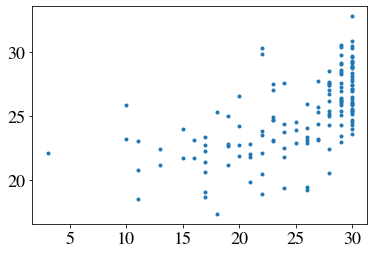

In [40]:
Y = all_data.Y.numpy()
Yest = res.predict(all_data.X, all_data.Z).numpy()
plt.plot(Y, Yest, ".")

In [18]:
res._prepare_hypotest()

In [19]:
res.hypo_test(Cmat=np.eye(1))

2024-03-08 09:49:10,463 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1.]])}.


{'pval': 0.2966048796125153, 'T_v': tensor(11.8299)}

In [20]:
torch.svd(res.hypo_utils.Q_mat_part).S

tensor([2.8986e+02, 9.9787e-01, 2.6951e-01, 2.3088e-01, 8.8919e-02, 2.0845e-02,
        1.6791e-02, 1.0680e-02, 5.7116e-03, 5.1549e-03, 3.9168e-03, 3.5008e-03,
        2.9215e-03, 2.4729e-03, 2.0387e-03, 1.8379e-03, 1.6804e-03, 1.5759e-03,
        1.3515e-03, 1.2938e-03, 1.1222e-03, 8.8350e-04, 7.4500e-04, 7.0903e-04])

In [21]:
res.get_covmat().beta

tensor([[ 44.9461, -24.9287,   2.2777, -16.4694,  10.2307,   1.5322,   4.8445,
         -24.1308,  24.6687, -38.9760],
        [-24.9287,  49.6906, -15.0366,  12.9357, -11.3516,   5.5716, -11.5929,
           8.7701, -28.6238,  24.1356],
        [  2.2777, -15.0366,  31.9810, -23.2351,   2.2462,   4.5686,  -1.0539,
          -2.4892,   6.0317,   7.4853],
        [-16.4694,  12.9357, -23.2351,  62.1052, -23.7968,  -5.6864,  -9.4192,
          14.4072, -19.1438, -17.9629],
        [ 10.2307, -11.3516,   2.2462, -23.7968,  39.7964, -14.8564,  -1.1778,
          -3.4414,  12.0714,  -1.4925],
        [  1.5322,   5.5716,   4.5686,  -5.6864, -14.8564,  40.2852, -15.0887,
         -17.5420,   5.3930,  -5.9137],
        [  4.8445, -11.5929,  -1.0539,  -9.4192,  -1.1778, -15.0887,  41.2990,
         -15.7616,   6.8756,   1.9995],
        [-24.1308,   8.7701,  -2.4892,  14.4072,  -3.4414, -17.5420, -15.7616,
          61.9129, -32.7373,  23.6528],
        [ 24.6687, -28.6238,   6.0317, -19.1438,